<a href="https://colab.research.google.com/github/alxmzr/Colab/blob/main/Backtesting_with_Backtrader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Trading Strategy: Back testing with Backtrader
# https://towardsdatascience.com/trading-strategy-back-testing-with-backtrader-6c173f29e37f

In [ ]:
pip install backtrader[plotting] yfinance

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 16,9
rcParams['figure.facecolor'] = '#eeeeee'
plt.title('dummy')
plt.plot([1,3,2,4])
plt.close()

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
2018-01-23, Close, 23.52
rsi: 77.73381082623325
2018-01-24, Close, 23.06
rsi: 68.9273761641653
2018-01-25, Close, 22.51
rsi: 60.1526030983921
2018-01-26, Close, 22.86
rsi: 63.32765683443308
2018-01-29, Close, 23.30
rsi: 66.96246585355588
2018-01-30, Close, 23.05
rsi: 63.2149371038208
2018-01-31, Close, 23.62
rsi: 67.6734588306056
2018-02-01, Close, 23.28
rsi: 62.788849061263285
2018-02-02, Close, 22.92
rsi: 57.89711617684352
2018-02-05, Close, 22.21
rsi: 49.825178397440894
2018-02-06, Close, 22.26
rsi: 50.414045104675154
2018-02-07, Close, 23.00
rsi: 57.47213310352543
2018-02-08, Close, 21.02
rsi: 40.652837855655974
2018-02-09, Close, 20.69
rsi: 38.683046324645396
2018-02-12, Close, 21.05
rsi: 42.02285969516864
2018-02-13, Close, 21.58
rsi: 46.69258729012702
2018-02-14, Close, 21.49
rsi: 46.01312800312385
2018-02-15, Close, 22.27
rsi: 52.497785940020215
2018-02-16, Close, 22.37
rsi:

<IPython.core.display.Javascript object>

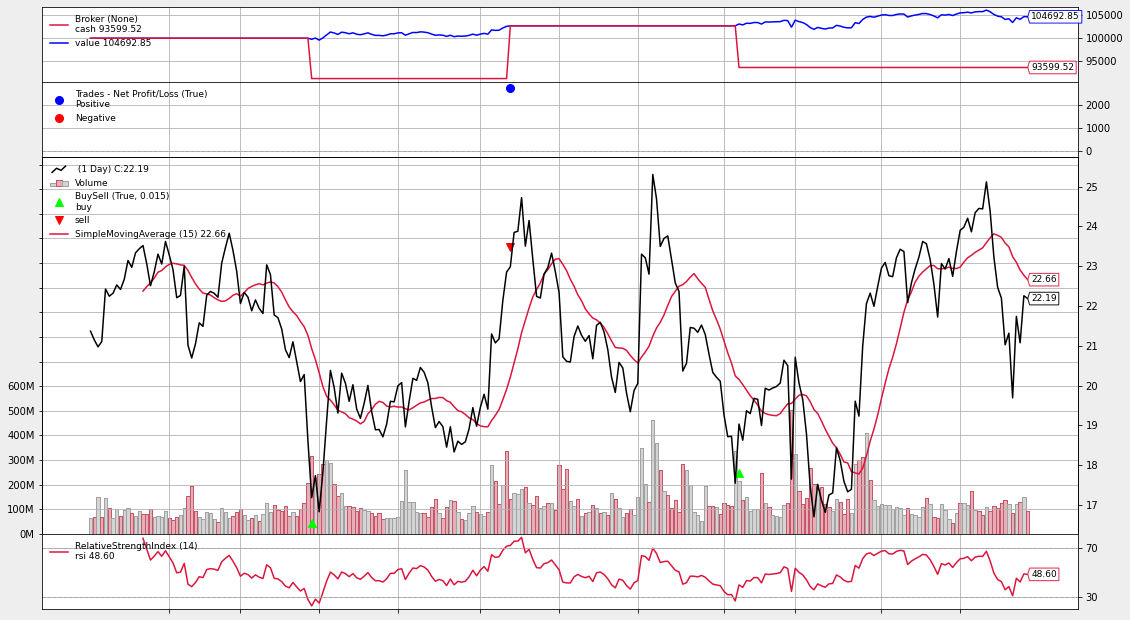

In [16]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime
import os.path
import sys
import backtrader as bt
import yfinance as yf

class TestStrategy(bt.Strategy):
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order = None
        self.buyprice = None
        self.buycomm = None

        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=15)
        self.rsi = bt.indicators.RelativeStrengthIndex()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        self.log('Close, %.2f' % self.dataclose[0])
        print('rsi:', self.rsi[0])
        if self.order:
            return

        if not self.position:
            if (self.rsi[0] < 30):
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy(size=500)

        else:
            if (self.rsi[0] > 70):
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell(size=500)


if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(TestStrategy)
    cerebro.broker.setcommission(commission=0.001)

    data = bt.feeds.PandasData(dataname=yf.download('TSLA', '2018-01-01', '2019-01-01'))

    cerebro.adddata(data)
    cerebro.broker.setcash(100000.0)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot()